In [1]:
import os
os.chdir("../")

In [2]:
from src.entity import AgentState
from langchain_core.prompts import ChatPromptTemplate
from langchain_cohere import ChatCohere
from langchain_core.output_parsers import StrOutputParser
from src.get_current_user import get_current_user
from src.check_revelance import check_relevance
from src.convert_to_sql import convert_nl_to_sql
from src.execute_sql import execute_sql
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
load_dotenv()

True

In [3]:
def generate_human_readable_answer(state: AgentState):
    sql = state["sql_query"]
    question = state['question']
    result = state["query_result"]
    current_user = state["current_user"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)
    print("Generating a human-readable answer.")
    system = f"""You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs with respect to {question}. Start the response with a friendly greeting that includes the user's name.
    """
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
                    {sql}

                    Result:
                    {result}

                    Formulate a clear and understandable error message in a single sentence, starting with 'Hello {current_user},' informing them about the issue."""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
                        {sql}

                        Result:
                        {result}

                        Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello {current_user},' and mention that there are no orders found."""
                    ),
                ]
            )
        else:
            # Handle displaying orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
                        {sql}

                        Result:
                        {result}

                        Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello {current_user},' and list each item ordered along with its price. For example: 'Hello Bob, you have ordered Lasagne for $14.0 and Spaghetti Carbonara for $15.0.'"""
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
                    {sql}

                    Result:
                    {result}

                    Formulate a clear and understandable confirmation message in a single sentence, starting with 'Hello {current_user},' confirming that your request has been successfully processed."""
                ),
            ]
        )

    llm = ChatCohere(model = "command-r-plus-08-2024",temperature=0)
    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({})
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state

In [4]:
def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "END"

In [5]:
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "END"

In [6]:
workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)

workflow.add_edge("get_current_user", "check_relevance")
workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "END": END,
    },
)

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "END": END,
    },
)
workflow.add_edge("convert_to_sql", "execute_sql")
workflow.add_edge("generate_human_readable_answer", END)
workflow.set_entry_point("get_current_user")

app = workflow.compile()

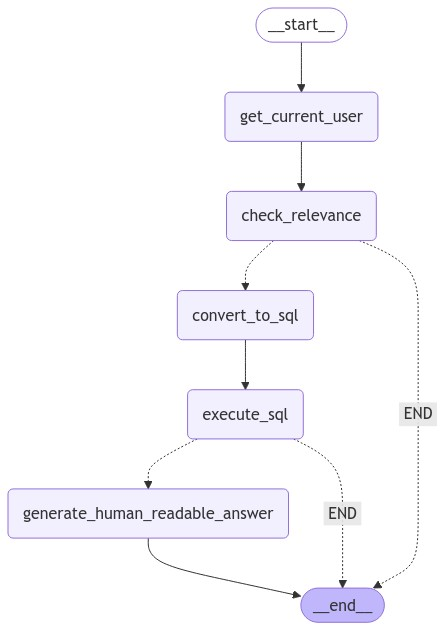

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [8]:
config = {"configurable": {"current_user_id": "2"}}
user_question_1 = "how much does food 3 cost?"
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=config)
print("Result:", result_1)

Retrieving the current user based on user ID.
Current user set to: User 2
Retrieved database schema.
Checking relevance of the question: how much does food 3 cost?
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'User 2': how much does food 3 cost?
Generated SQL query: SELECT food.price FROM food WHERE food.id = 3;
Executing SQL query: SELECT food.price FROM food WHERE food.id = 3;
Raw SQL Query Result: [{'price': 42.0}]
SQL SELECT query executed successfully.
Generating a human-readable answer.
Generated human-readable answer.
Result: {'question': 'how much does food 3 cost?', 'sql_query': 'SELECT food.price FROM food WHERE food.id = 3;', 'query_result': 'Hello User 2, the price of food item 3 is $42.0.', 'query_rows': [{'price': 42.0}], 'current_user': 'User 2', 'attempts': 0, 'relevance': 'relevant', 'sql_error': False}


In [9]:
result_1['query_result']

'Hello User 2, the price of food item 3 is $42.0.'

In [11]:
user_question_1 = "Show me my orders"
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=config)
print("Result:", result_1)

Retrieving the current user based on user ID.
Current user set to: User 2
Retrieved database schema.
Checking relevance of the question: Show me my orders
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'User 2': Show me my orders
Generated SQL query: SELECT food.name AS food_name, food.price AS price FROM orders INNER JOIN food ON orders.food_id = food.id INNER JOIN users ON orders.user_id = users.id WHERE users.id = 2;
Executing SQL query: SELECT food.name AS food_name, food.price AS price FROM orders INNER JOIN food ON orders.food_id = food.id INNER JOIN users ON orders.user_id = users.id WHERE users.id = 2;
Raw SQL Query Result: [{'food_name': 'Food 14', 'price': 48.8}, {'food_name': 'Food 8', 'price': 25.35}, {'food_name': 'Food 1', 'price': 38.31}, {'food_name': 'Food 2', 'price': 34.57}, {'food_name': 'Food 4', 'price': 15.42}, {'food_name': 'Food 7', 'price': 6.02}, {'food_name': 'Food 11', 'price': 36.42}, {'food_name': 'Food 6', '